# Determining patient fate

In [1]:
import scanpy as sc
import pandas as pd
import cellrank as cr
import ehrapy as ep
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [4]:
df_annotations = pd.read_csv("public-annotations.csv")

filenames = pd.read_csv("filenames.csv", index_col=None)

df_annotations = df_annotations[
    df_annotations.filename.isin(list(filenames["filename"]))
].reset_index(drop=True)
df_annotations["geographic_mean"] = df_annotations["S-Global"]

In [5]:
# Old cutoff by XZ
df_annotations["geographic_mean"].replace(
    [
        0,
        1,
        2,
    ],
    "Normal",
    inplace=True,
)
df_annotations["geographic_mean"].replace([3, 4, 5], "Mild", inplace=True)
df_annotations["geographic_mean"].replace(
    [6, 7, 8, 9, 10, 11], "Moderate", inplace=True
)
df_annotations["geographic_mean"].replace(
    [12, 13, 14, 15, 16, 17, 18], "Severe", inplace=True
)

In [6]:
# New cutoff by PE/LH
normal_conditions = (
    df_annotations[["S-A", "S-B", "S-C", "S-D", "S-E", "S-F"]] == 0
).all(axis=1)
mild_conditions = (df_annotations[["S-A", "S-B", "S-C", "S-D", "S-E", "S-F"]] == 1).any(
    axis=1
) & (~((df_annotations[["S-A", "S-B", "S-C", "S-D", "S-E", "S-F"]] > 1).any(axis=1)))
moderate_conditions = (
    df_annotations[["S-A", "S-B", "S-C", "S-D", "S-E", "S-F"]] >= 2
).any(axis=1)
severe_conditions = (
    (df_annotations[["S-A", "S-B", "S-C", "S-D", "S-E", "S-F"]] == 3).any(axis=1)
) & (df_annotations["S-Global"] >= 7)
critical_conditions = (
    (df_annotations[["S-A", "S-B", "S-C", "S-D", "S-E", "S-F"]] == 3).sum(axis=1) >= 2
) & (df_annotations["S-Global"] >= 11)

df_annotations.loc[normal_conditions, "severity"] = "Normal"
df_annotations.loc[mild_conditions, "severity"] = "Mild"
df_annotations.loc[moderate_conditions, "severity"] = "Moderate"
df_annotations.loc[severe_conditions, "severity"] = "Severe"
df_annotations.loc[critical_conditions, "severity"] = "Critical"

In [7]:
df_annotations["severity"].value_counts()

severity
Moderate    53
Critical    37
Severe      26
Mild        22
Normal      18
Name: count, dtype: int64

In [8]:
adata = sc.read_csv(f"embeddings.csv")
adata.obs["geographic_mean"] = df_annotations["geographic_mean"].values
adata.obs["severity"] = df_annotations["severity"].values
adata.obs["image_name"] = filenames["filename"].values

In [9]:
# palette = {
#     "Normal": "yellowgreen",
#     "Mild": "turquoise",
#     "Moderate": "orange",
#     "Severe": "red",
#     "Critical": "purple"
# }

import matplotlib.colors as mcolors

palette = {
    "Normal": mcolors.to_rgba("#1CFF4B"),
    "Mild": mcolors.to_rgba("#04C6DB"),
    "Moderate": mcolors.to_rgba("#1222F0"),
    "Severe": mcolors.to_rgba("#AF00DB"),
    "Critical": mcolors.to_rgba("#FF1202"),
}

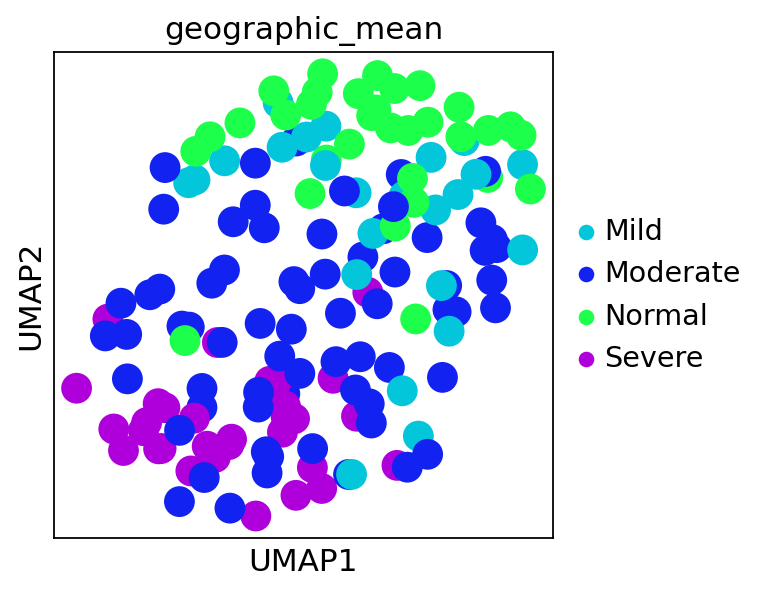

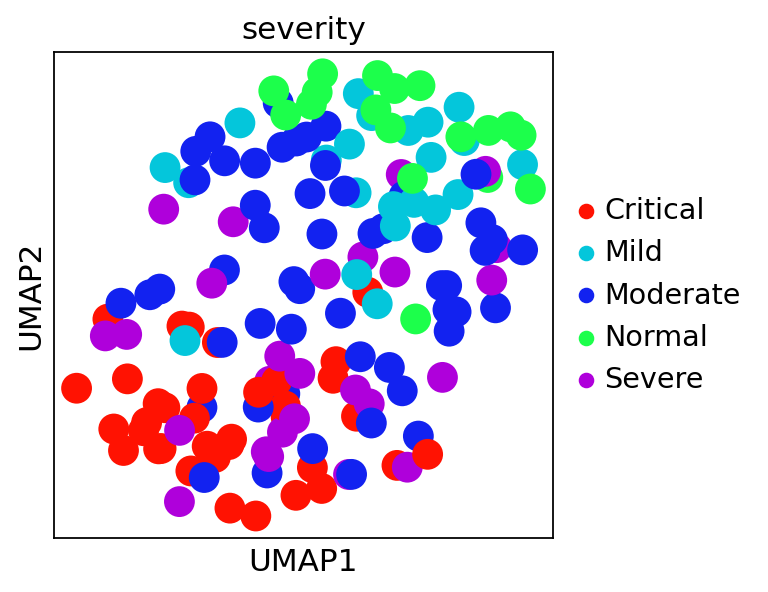

In [10]:
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata, n_components=3)
ep.pl.umap(adata, color=["geographic_mean"], palette=palette)
ep.pl.umap(adata, color=["severity"], palette=palette, show=False)
plt.savefig("../figure_parts/severity.pdf", format="pdf")

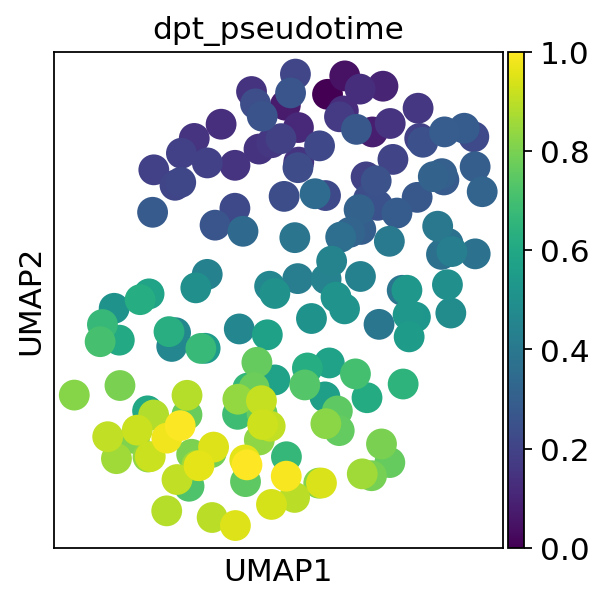

In [11]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["geographic_mean"] == "Normal")[10]
ep.tl.dpt(adata)
ep.pl.umap(adata, color="dpt_pseudotime", show=False)
plt.tight_layout()
plt.savefig("../figure_parts/pseudotime.pdf", format="pdf")

  0%|          | 0/156 [00:00<?, ?cell/s]

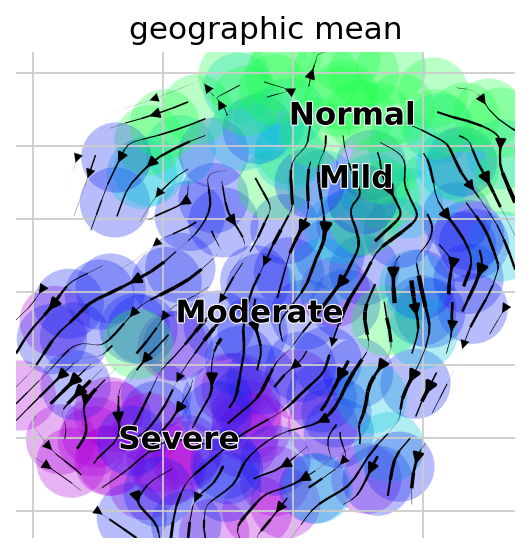

In [12]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["geographic_mean"] == "Normal")[10]
ep.tl.dpt(adata)
pk = cr.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix(threshold_scheme="soft")
pk.plot_projection(
    basis="umap",
    stream=True,
    color="geographic_mean",
    density=1,
    smooth=True,
    size=4000,
)

In [13]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["severity"] == "Normal")[10]
ep.tl.dpt(adata)
pk = cr.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix(threshold_scheme="soft")

  0%|          | 0/156 [00:00<?, ?cell/s]

PseudotimeKernel[n=156, dnorm=False, scheme='soft', b=10.0, nu=0.5]

saving figure to file ../figure_parts/project_flow.pdf


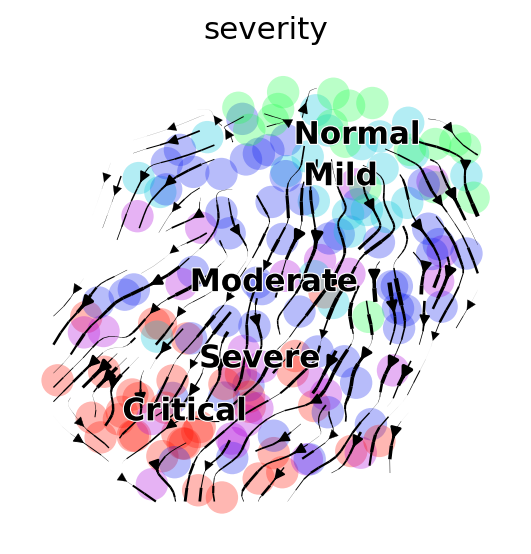

In [14]:
plt.rcParams["axes.grid"] = False
pk.plot_projection(
    basis="umap",
    stream=True,
    color="severity",
    density=1,
    smooth=True,
    size=850,
    add_margin=0.1,
    save="../figure_parts/project_flow.pdf",
)

  0%|          | 0/100 [00:00<?, ?sim/s]

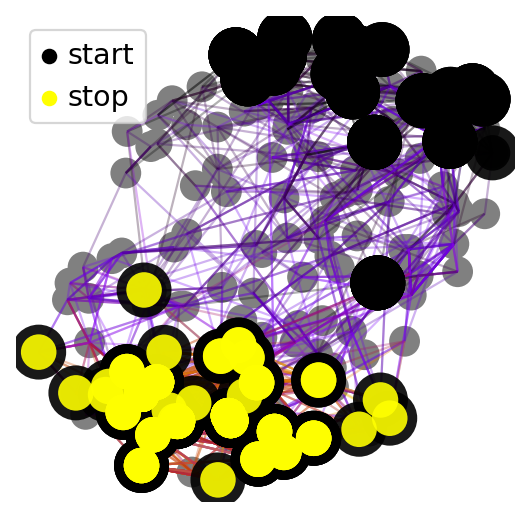

In [15]:
pk.plot_random_walks(
    basis="umap", start_ixs={"severity": ["Normal"]}, n_sims=100, ixs_legend_loc="best"
)

The images that are not quite where they should be:

**Normal**

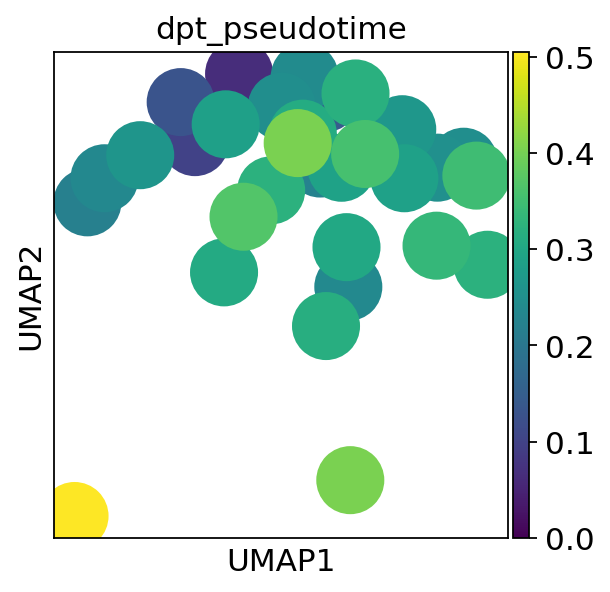

In [16]:
ep.pl.umap(adata[adata.obs.geographic_mean == "Normal"], color="dpt_pseudotime")

In [17]:
normal_only = adata.obs[adata.obs.geographic_mean == "Normal"].sort_values(
    by="dpt_pseudotime"
)
normal_only

,geographic_mean,severity,image_name,dpt_pseudotime
148,Normal,Normal,covid-19-pneumonia-38-pa.jpg,0.000000
152,Normal,Normal,covid-19-pneumonia-58-prior.jpg,0.063657
151,Normal,Normal,covid-19-pneumonia-44-day-0.jpeg,0.098984
145,Normal,Normal,covid-19-pneumonia-20.jpg,0.131560
153,Normal,Normal,covid-19-pneumonia-58-day-9.jpg,0.142481
106,Normal,Moderate,legionella-pneumonia-2.jpg,0.217048
150,Normal,Normal,covid-19-pneumonia-35-2.jpg,0.221323
135,Normal,Moderate,covid-19-pneumonia-40.jpg,0.234752
118,Normal,Mild,covid-19-pneumonia-evolution-over-a-week-1-day...,0.236816
155,Normal,Normal,covid-19-pneumonia-mild.JPG,0.241555


In [18]:
normal_only.loc["148"]

geographic_mean                          Normal
severity                                 Normal
image_name         covid-19-pneumonia-38-pa.jpg
dpt_pseudotime                              0.0
Name: 148, dtype: object

## Mild

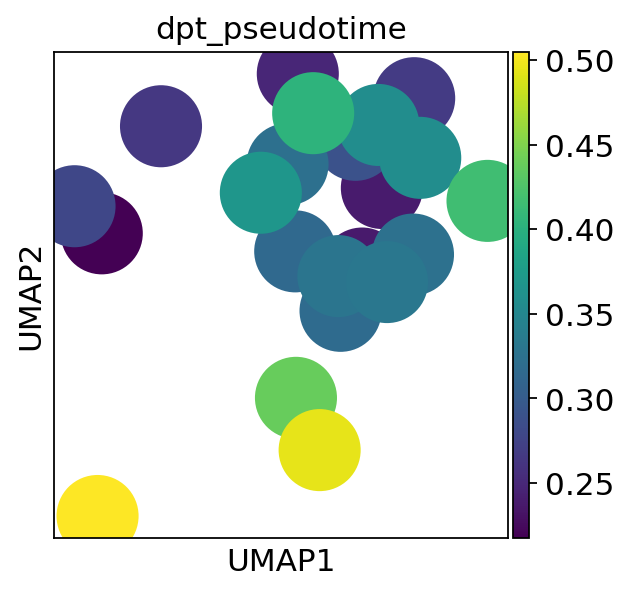

In [19]:
ep.pl.umap(adata[adata.obs.severity == "Mild"], color="dpt_pseudotime")

In [20]:
normal_only = adata.obs[adata.obs.severity == "Mild"].sort_values(
    by="dpt_pseudotime", ascending=False
)
normal_only

,geographic_mean,severity,image_name,dpt_pseudotime
84,Normal,Mild,cavitating-pneumonia-4-day28-PA.png,0.504983
82,Moderate,Mild,chlamydia-pneumonia-PA.png,0.493893
90,Mild,Mild,covid-19-pneumonia-rapidly-progressive-3-days.jpg,0.437735
128,Mild,Mild,post-intubuation-pneumomediastium-and-pneumoth...,0.416809
133,Normal,Mild,covid-19-pneumonia-43-day0.jpeg,0.402957
113,Normal,Mild,covid-19-pneumonia-24-day7.jpg,0.368501
116,Mild,Mild,covid-19-pneumonia-evolution-over-a-week-1-day...,0.357087
139,Normal,Mild,figure1-5e7c1b8d98c29ab001275405-98.jpeg,0.356784
100,Mild,Mild,pneumocystis-pneumonia-8.jpg,0.331687
123,Moderate,Mild,RX-torace-a-letto-del-paziente-in-unica-proiez...,0.329663


## Medium

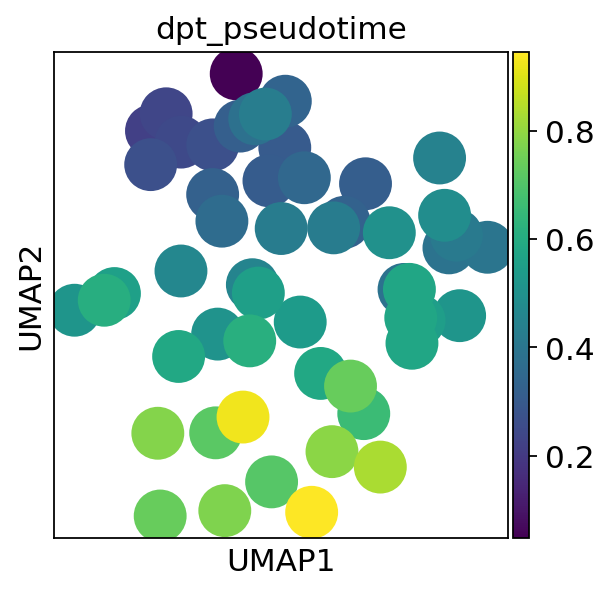

In [21]:
ep.pl.umap(adata[adata.obs.severity == "Moderate"], color="dpt_pseudotime")

In [22]:
normal_only = adata.obs[adata.obs.severity == "Moderate"].sort_values(
    by="dpt_pseudotime", ascending=False
)
normal_only

,geographic_mean,severity,image_name,dpt_pseudotime
47,Mild,Moderate,2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg,0.946343
20,Moderate,Moderate,1-s2.0-S0929664620300449-gr2_lrg-d.jpg,0.927422
57,Mild,Moderate,kjr-21-e24-g002-l-a.jpg,0.831903
56,Moderate,Moderate,kjr-21-e24-g001-l-a.jpg,0.789722
21,Moderate,Moderate,covid-19-pneumonia-15-PA.jpg,0.781163
44,Moderate,Moderate,6CB4EFC6-68FA-4CD5-940C-BEFA8DAFE9A7.jpeg,0.772996
62,Moderate,Moderate,1-s2.0-S1684118220300682-main.pdf-003-b2.png,0.737372
70,Moderate,Moderate,kjr-21-e25-g001-l-a.jpg,0.737170
40,Moderate,Moderate,7AF6C1AF-D249-4BD2-8C26-449304105D03.jpeg,0.715906
55,Moderate,Moderate,ciaa199.pdf-001-b.png,0.710202


## Severe

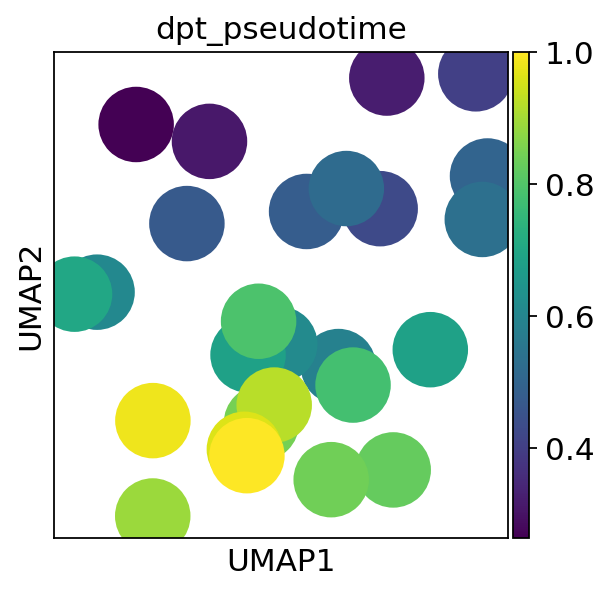

In [23]:
ep.pl.umap(adata[adata.obs.severity == "Severe"], color="dpt_pseudotime")

In [24]:
adata[adata.obs.severity == "Severe"].obs.sort_values(
    by="dpt_pseudotime", ascending=False
)

,geographic_mean,severity,image_name,dpt_pseudotime
46,Moderate,Severe,F63AB6CE-1968-4154-A70F-913AF154F53D.jpeg,1.000000
54,Moderate,Severe,7E335538-2F86-424E-A0AB-6397783A38D0.jpeg,0.981315
35,Moderate,Severe,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,0.961324
28,Severe,Severe,pneumonia-7.jpg,0.920858
13,Moderate,Severe,ryct.2020200028.fig1a.jpeg,0.887931
14,Severe,Severe,jkms-35-e79-g001-l-a.jpg,0.845008
39,Moderate,Severe,23E99E2E-447C-46E5-8EB2-D35D12473C39.png,0.839051
48,Moderate,Severe,93FE0BB1-022D-4F24-9727-987A07975FFB.jpeg,0.825884
38,Moderate,Severe,1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg,0.790421
51,Moderate,Severe,5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg,0.779597


## Critical

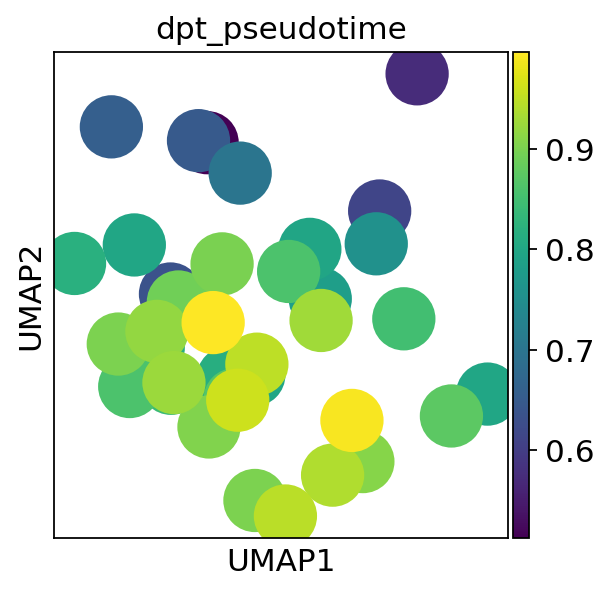

In [25]:
ep.pl.umap(adata[adata.obs.severity == "Critical"], color="dpt_pseudotime")

In [26]:
adata[adata.obs.geographic_mean == "Severe"].obs.sort_values(
    by="dpt_pseudotime", ascending=False
)

,geographic_mean,severity,image_name,dpt_pseudotime
32,Severe,Critical,E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg,0.996933
29,Severe,Critical,39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg,0.993020
9,Severe,Critical,nejmoa2001191_f3-PA.jpeg,0.960734
5,Severe,Critical,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,0.948331
8,Severe,Critical,nejmoa2001191_f1-PA.jpeg,0.947326
12,Severe,Critical,ryct.2020200034.fig2.jpeg,0.939197
4,Severe,Critical,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,0.928153
7,Severe,Critical,nCoV-radiol.2020200269.fig1-day7.jpeg,0.923782
28,Severe,Severe,pneumonia-7.jpg,0.920858
6,Severe,Critical,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,0.919188
